Correct data for background and save the results as an extra layer in the anndata object:

Load relevant packages and data:

In [1]:
import sys,os
path = '/nfs/team283/aa16/InSituCellTools/'
os.chdir(path)
sys.path.append(path)

In [2]:
import pickle
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import diffxpy.api as de
from IPython.display import Image
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
from isctools.ProbeCounts__GeneralModel_V2_SmoothedOverdispersion import ProbeCounts_GeneralModel_V2
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


In [3]:
adata_wta = pickle.load(open(path + "data/nanostringWTA_fetailBrain_AnnData.p", "rb" ))

In [4]:
adata_wta = adata_wta[adata_wta.obs['GoodQuality'],:]

Fit seperate model to each slide:

In [5]:
slides = np.array(('00MR', '00MU', ('00MV', '00MV-2'), '00MW'))
adata_slide = list()
for j in range(len(slides)):
    adata_slide.append(adata_wta[[adata_wta.obs['slide'][i] in slides[j] for i in range(len(adata_wta.obs['slide']))]])
    print(np.shape(adata_slide[j]))

(66, 18416)
(74, 18416)
(52, 18416)
(63, 18416)


In [6]:
counts_geneProbes = list()
counts_negativeProbes = list()
counts_nuclei = list()

for i in range(len(slides)):    
    
    counts_geneProbes.append(np.asarray(adata_slide[i][:,np.array(adata_slide[i].var != 'NegProbe-WTX').squeeze()].X))
    counts_negativeProbes.append(np.asarray(adata_slide[i][:,np.array(adata_slide[i].var =='NegProbe-WTX').squeeze()].X))
    counts_nuclei.append(np.asarray(adata_slide[i].obs['nuclei']).reshape(len(adata_slide[i].obs['nuclei']),1).squeeze())

We can just load an existing fitted model:

In [7]:
models = pickle.load(open("/nfs/team283/aa16/KR_NAS/data/CC-V2_AllModels2.p", "rb" ))

Compute X_corrected and save results into anndata object:

In [8]:
for i in range(len(slides)):
    ProbeCounts_GeneralModel_V2.compute_X_corrected(models[i])

In [9]:
adata_wta.layers['X_Corrected_V2'] = adata_wta.X
for j in range(len(slides)):
    subset_cells = [adata_wta.obs['slide'][i] in slides[j] for i in range(len(adata_wta.obs['slide']))]
    subset_genes = [adata_wta.var_names[i] in models[j].var_names for i in range(len(adata_wta.var_names))]
    adata_wta.layers['X_Corrected_V2'][np.ix_(subset_cells, subset_genes)]= models[j].X_corrected_mean

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.X` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Save corrected data:

In [12]:
pickle.dump(adata_wta, open("/nfs/team283/aa16/KR_NAS/data/nanostringWTA_fetailBrain_AnnData.p", "wb" ))
pickle.dump(adata_wta, open("/nfs/team283/aa16/InSituCellTools/data/nanostringWTA_fetailBrain_AnnData.p", "wb" ))

Check what X_corrected_V2 looks like for all slides:

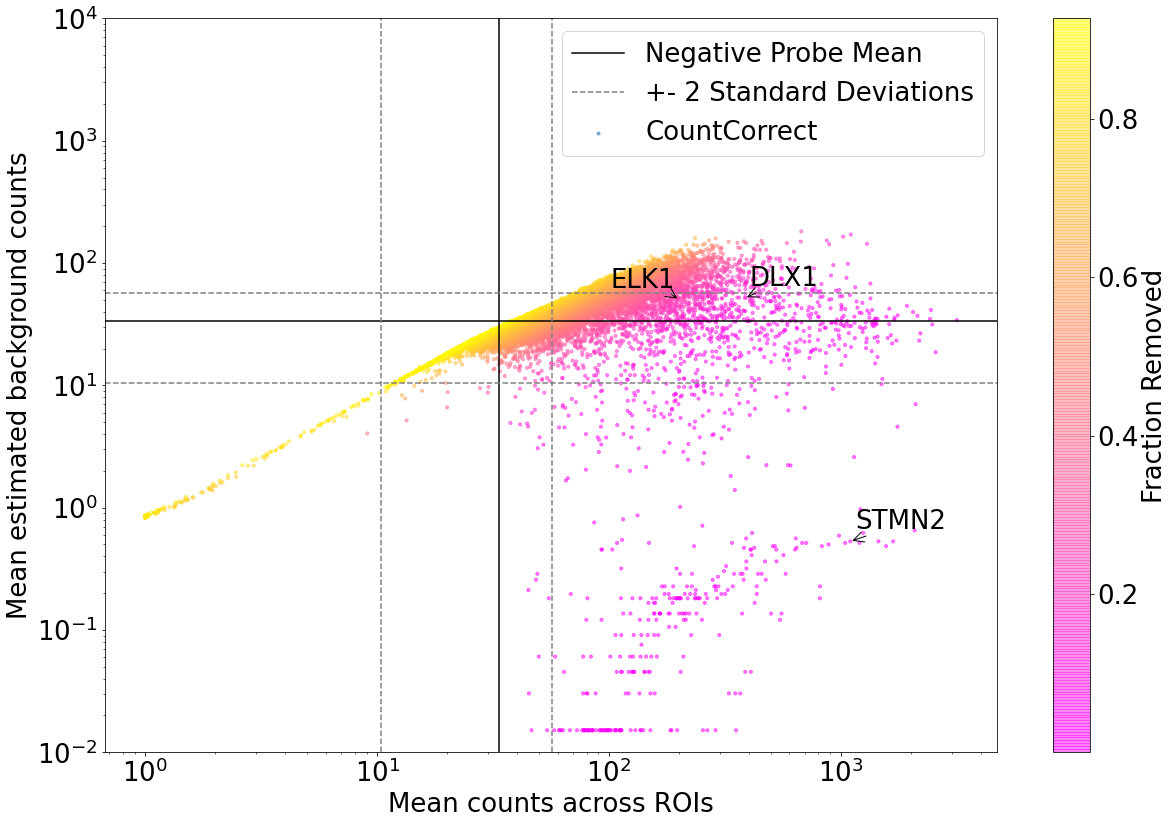

In [10]:
genesOfInterest = np.array(('DLX1', 'STMN2', 'ELK1'))
ProbeCounts_GeneralModel_V2.plot_X_corrected_overview5(models[0], genesOfInterest, cmap = 'spring')

In [11]:
import imp
import isctools
from isctools import pymc3_model
imp.reload(isctools.pymc3_model)
imp.reload(isctools.ProbeCounts__GeneralModel_V2_SmoothedOverdispersion)
from isctools.ProbeCounts__GeneralModel_V2_SmoothedOverdispersion import ProbeCounts_GeneralModel_V2

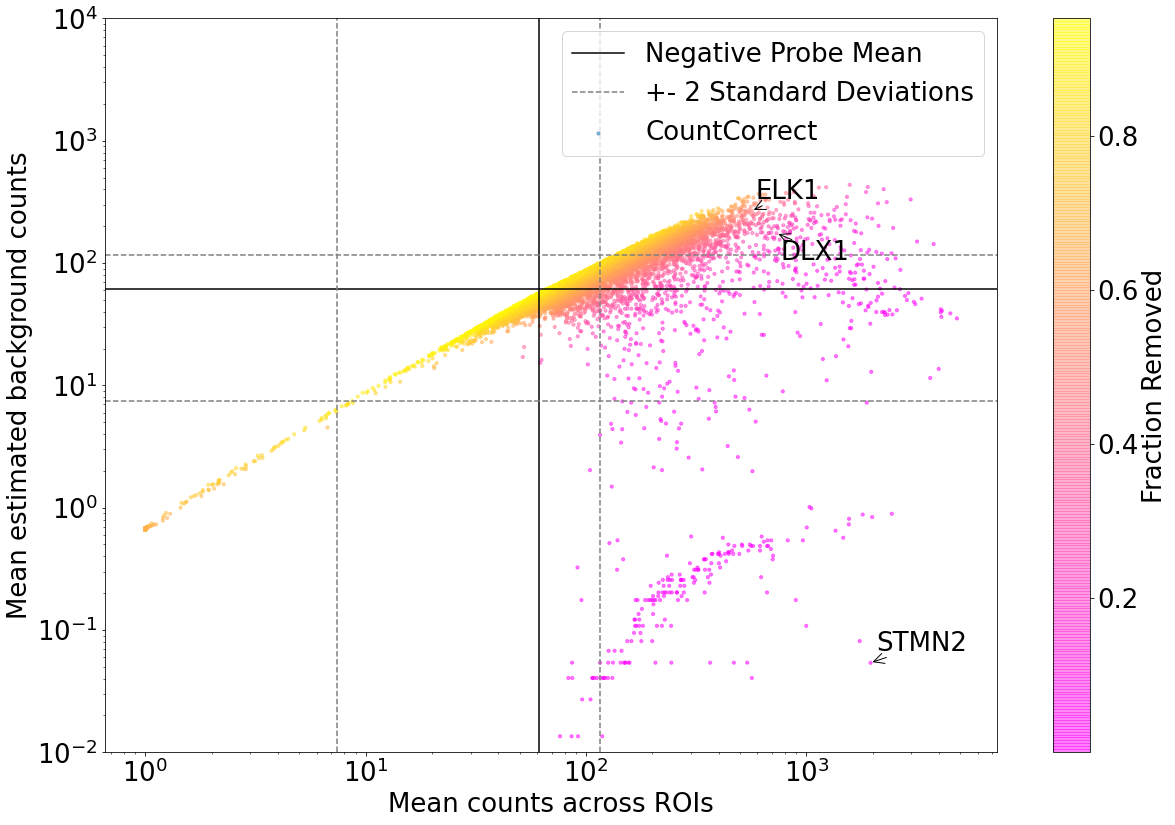

In [12]:
genesOfInterest = np.array(('DLX1', 'STMN2', 'ELK1'))
ProbeCounts_GeneralModel_V2.plot_X_corrected_overview5(models[1], genesOfInterest,
                                                       cmap = 'spring',
                                                       saveFig='/nfs/team283/aa16/KR_NAS/0_publication_figures/Figure1J_CC-V2_overview.pdf',
                                                       correction = 1)

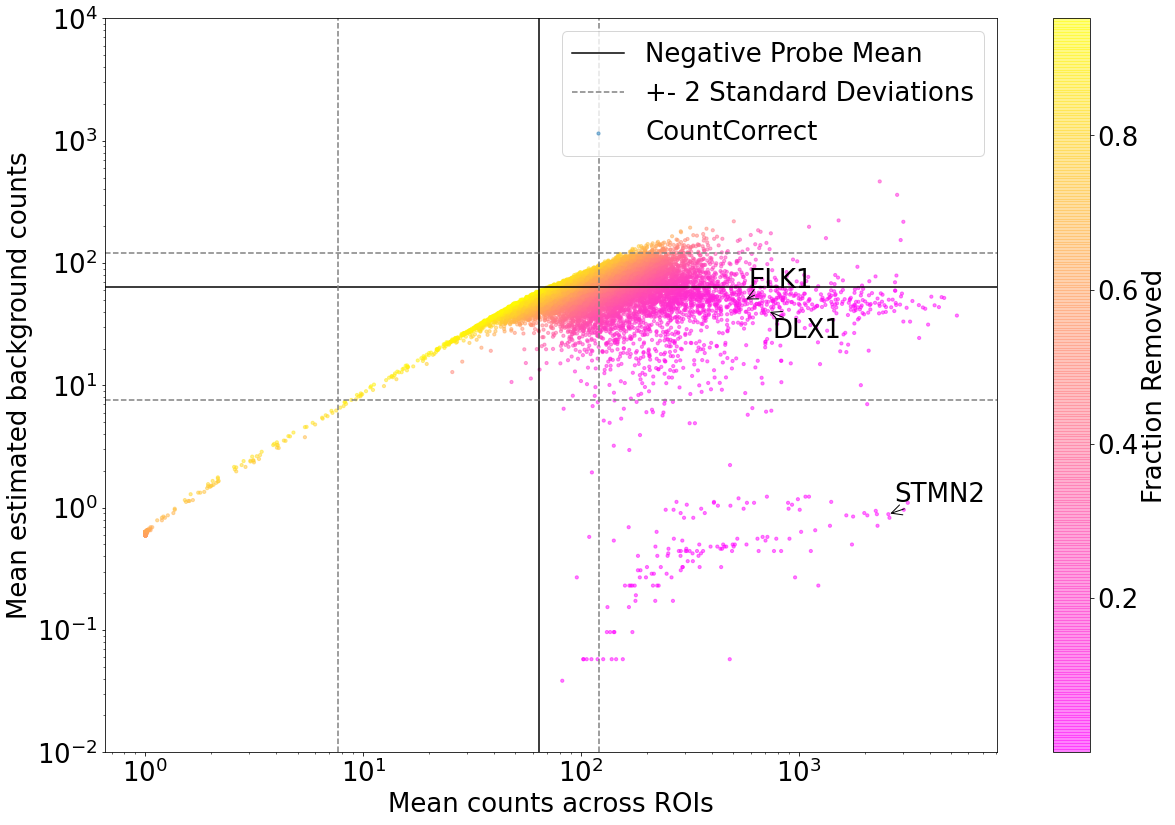

In [13]:
genesOfInterest = np.array(('DLX1', 'STMN2', 'ELK1'))
ProbeCounts_GeneralModel_V2.plot_X_corrected_overview5(models[2], genesOfInterest, cmap = 'spring')

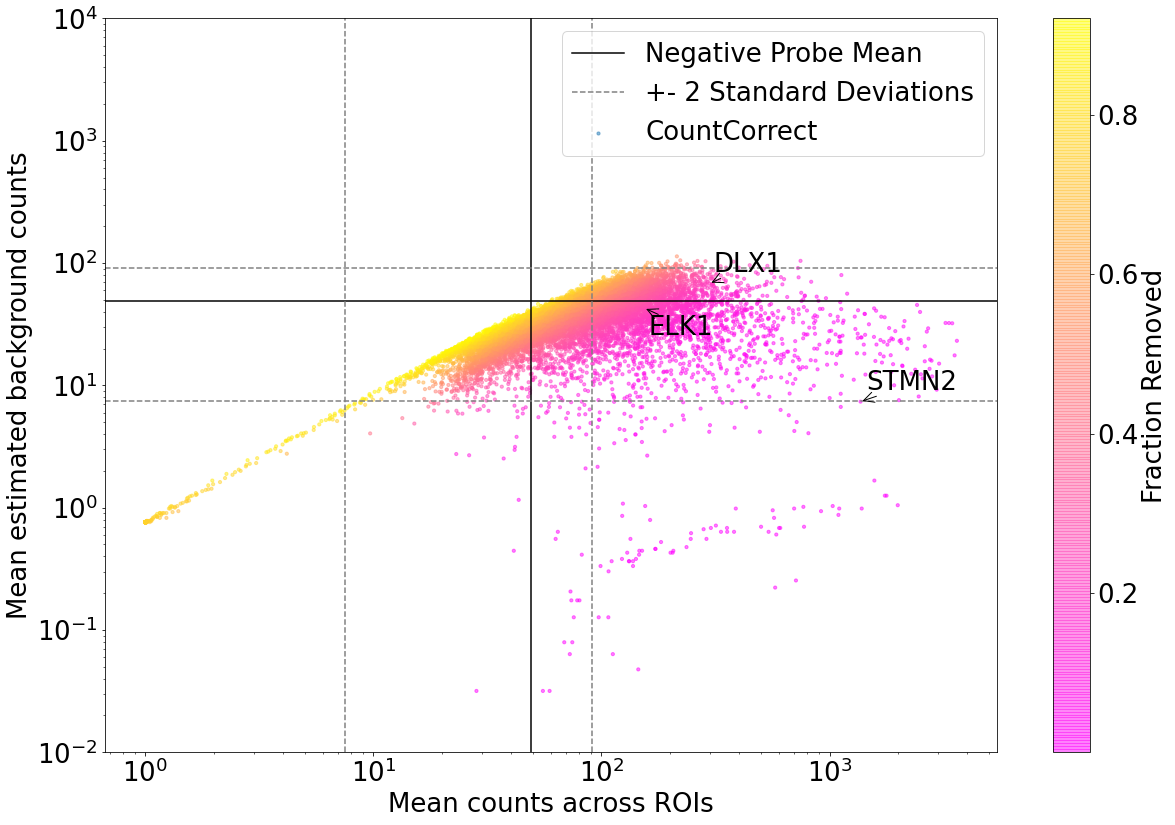

In [14]:
genesOfInterest = np.array(('DLX1', 'STMN2', 'ELK1'))
ProbeCounts_GeneralModel_V2.plot_X_corrected_overview5(models[3], genesOfInterest, cmap = 'spring')

Example genes:

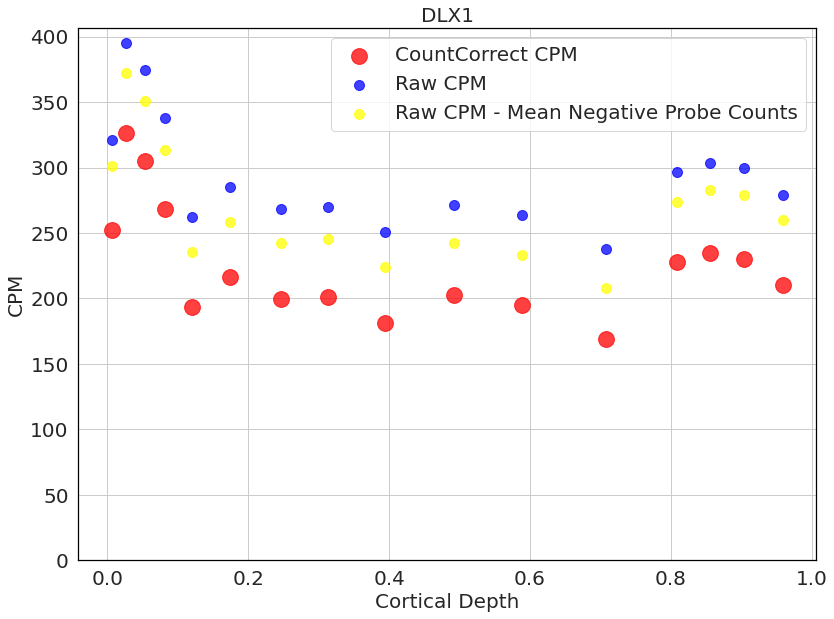

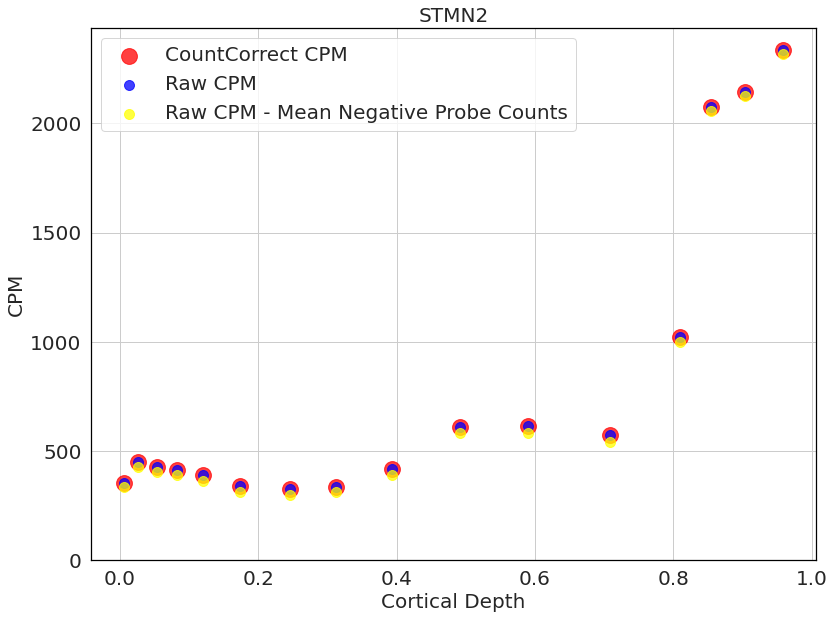

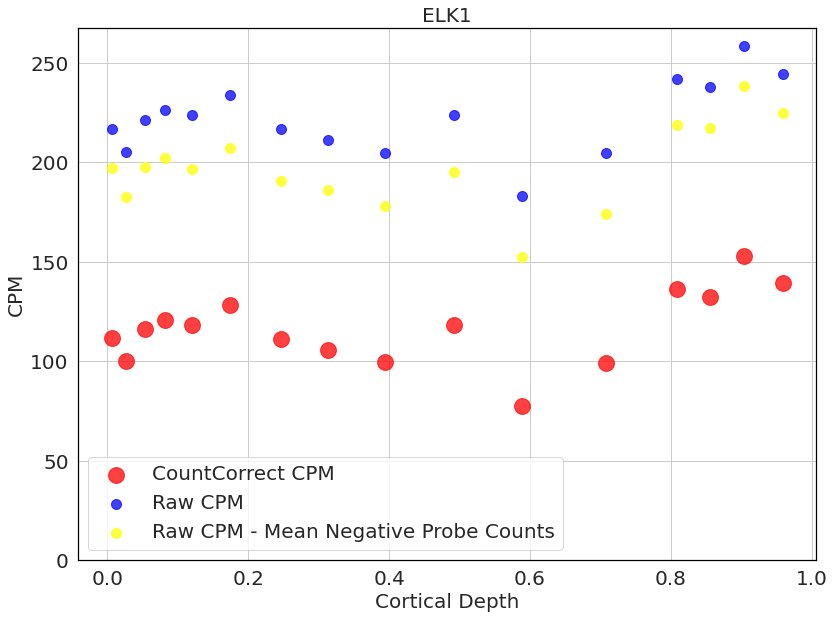

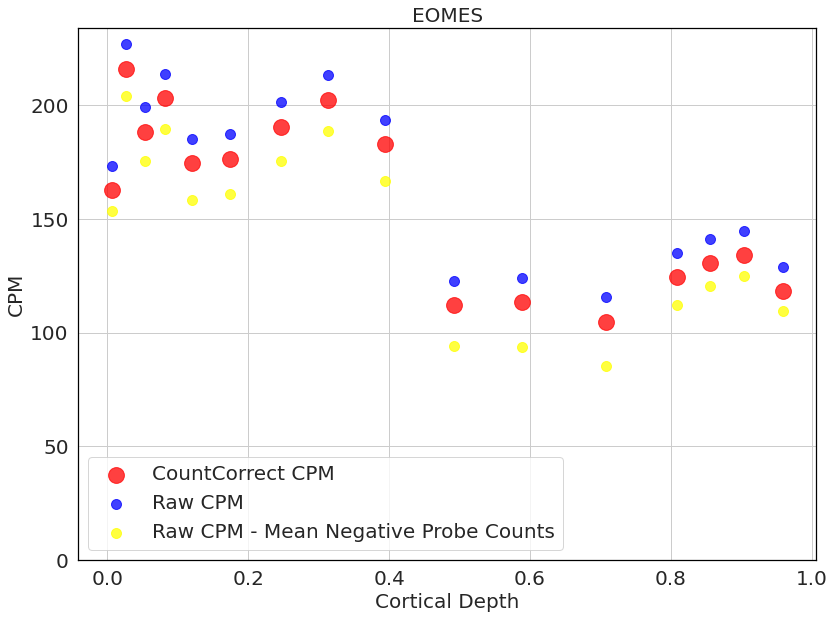

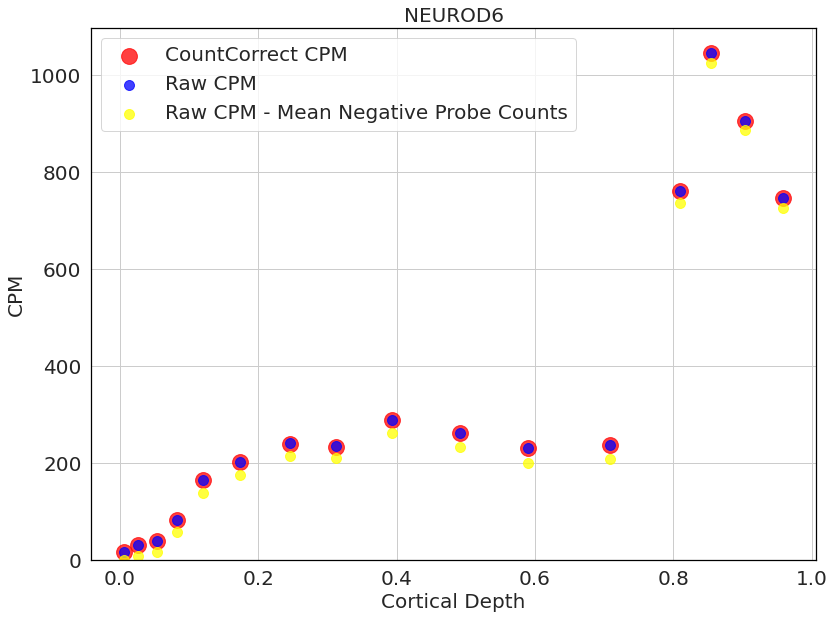

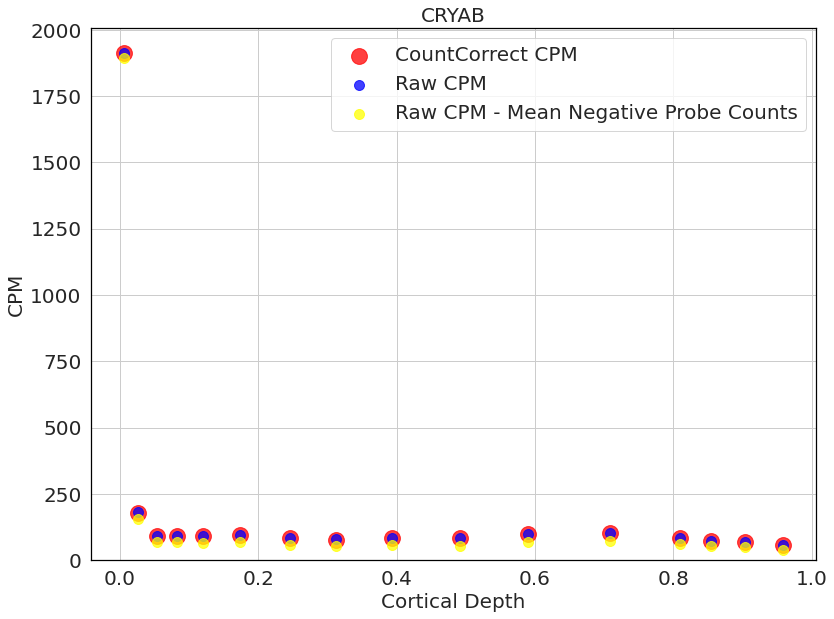

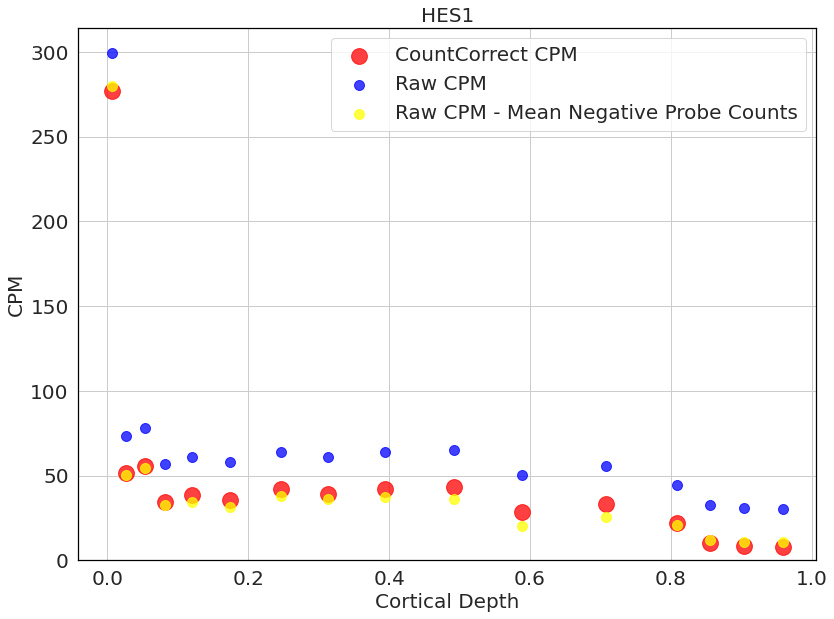

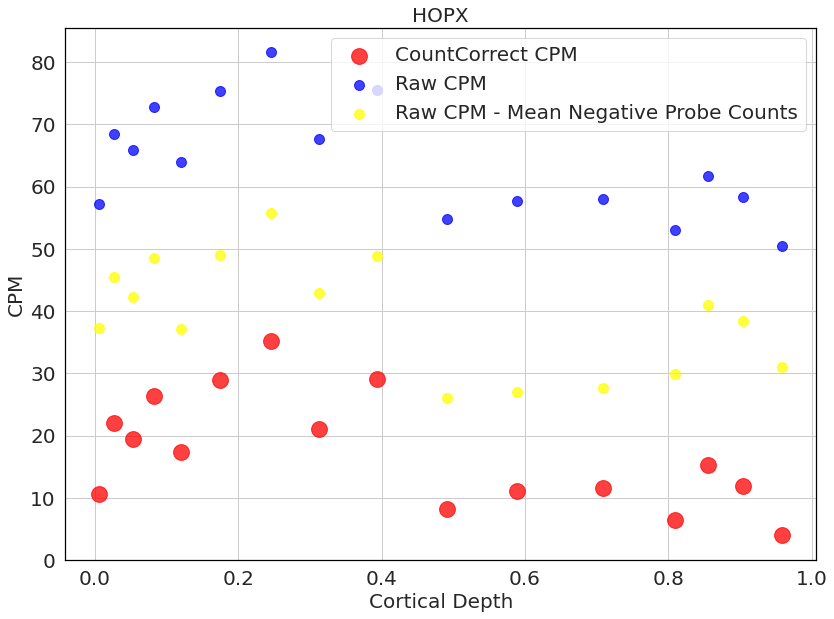

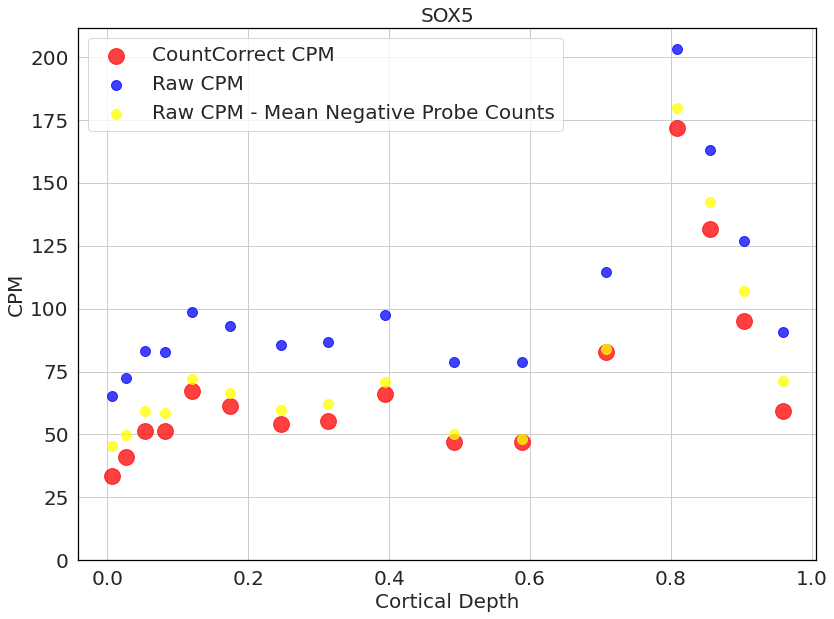

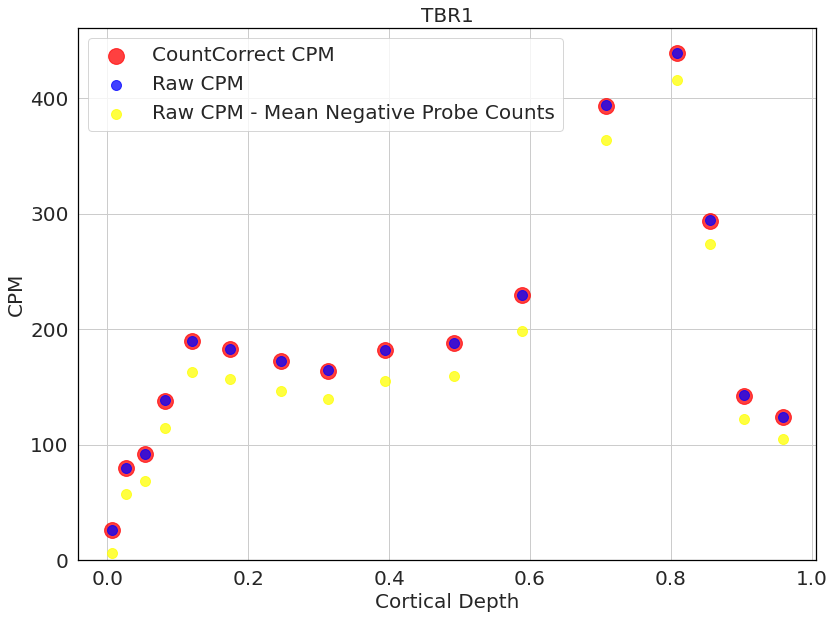

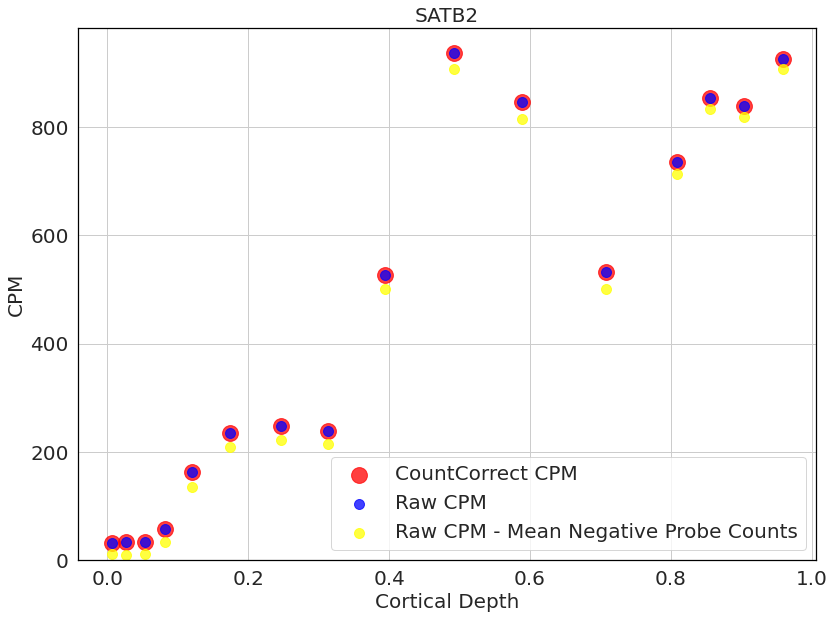

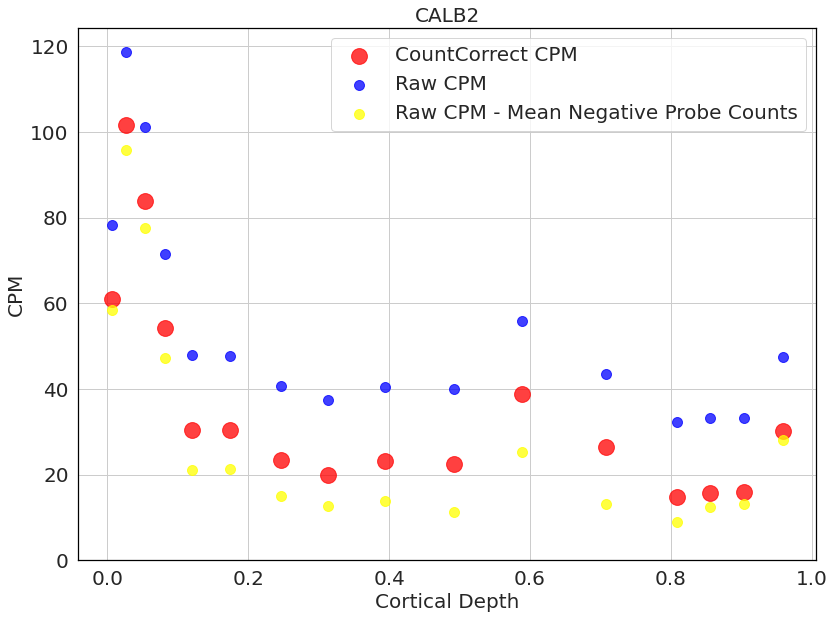

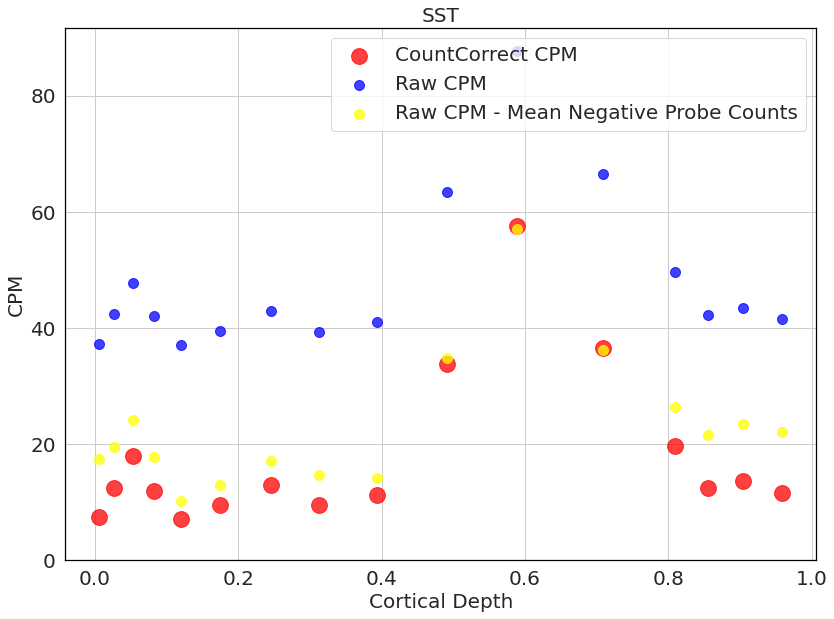

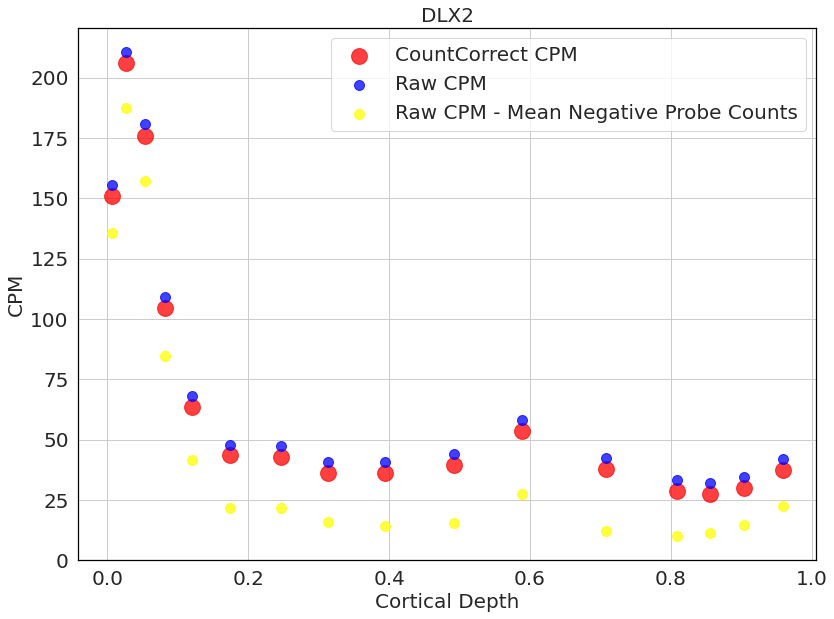

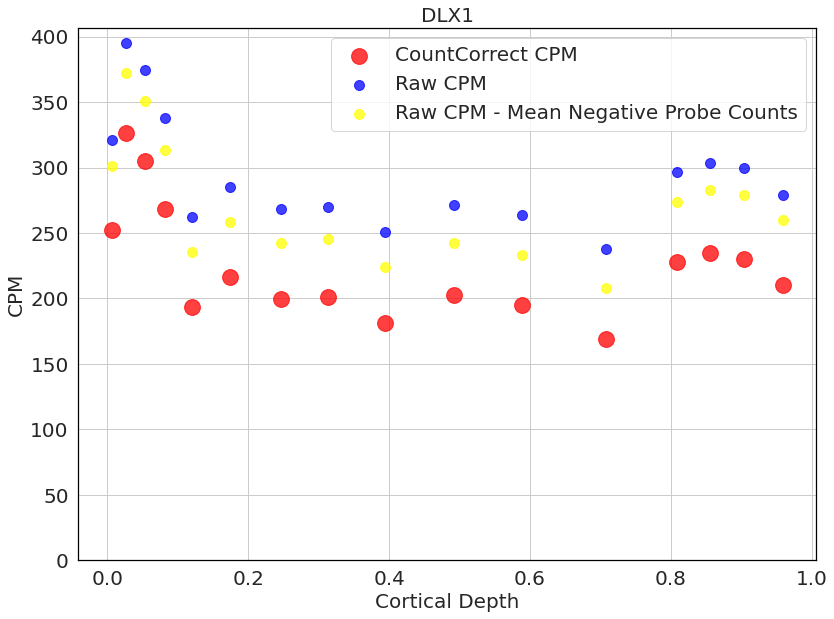

In [182]:
j = 1
example_genes = np.array(('DLX1', 'STMN2', 'ELK1', 'EOMES', 'NEUROD6', 'CRYAB', 'HES1', 'HOPX', 'SOX5', 'TBR1', 'SATB2', 'CALB2', 'SST', 'DLX2', 'DLX1'))
x = np.asarray(adata_slide[j].obs['VCDepth'])
order = np.where([adata_slide[j].obs['Radial_position'][i] == 2 for i in range(len(adata_slide[j].obs['Radial_position']))])[0]
ProbeCounts_GeneralModel_V2.plot_X_corrected_exampleGenes1(models[j], x, order, example_genes, saveFig = '/nfs/team283/aa16/KR_NAS/0_publication_figures/SuppFig_ExampleGeneCorrections_CC-V2')

Do the remaining plots only for one slide:

In [15]:
mod1 = models[1]
adata_wta = adata_slide[1]

In [16]:
# Get our HOPXpos and EOMESpos AOIs:
order_HOPX = np.where([adata_wta.obs['AOI_type'][i] == 'HOPXpos' for i in range(len(adata_wta.obs['Radial_position']))])[0]
order_EOMES = np.where([adata_wta.obs['AOI_type'][i] == 'EOMESpos' for i in range(len(adata_wta.obs['Radial_position']))])[0]
order = np.concatenate([order_HOPX, order_EOMES])

# Get cpm for both corrected (isc_cpm) and uncorrected data (cpm):
total_counts = np.sum(mod1.X_data, axis = 1)
cpm = mod1.X_data/total_counts.reshape(np.shape(mod1.X_data)[0],1)*10**6
isc_cpm = mod1.X_corrected_mean/total_counts.reshape(np.shape(mod1.X_data)[0],1)*10**6

# Put data into two AnnData objects:
adata_cpm = adata = sc.AnnData(X=cpm[order],
                               obs=pd.DataFrame(data = np.concatenate([np.repeat('HOPXpos', len(order_HOPX)),
                                                                      np.repeat('EOMESpos', len(order_EOMES))]),
                                                columns = ['Cell Type']))

adata_isc_cpm = adata = sc.AnnData(X=isc_cpm[order],
                               obs=pd.DataFrame(data = np.concatenate([np.repeat('HOPXpos', len(order_HOPX)),
                                                                      np.repeat('EOMESpos', len(order_EOMES))]),
                                                columns = ['Cell Type']))

# Perform differential expression with diffxpy for both cases:

test_rank_cpm = de.test.rank_test(
    data=adata_cpm,
    grouping="Cell Type",
    gene_names = mod1.var_names,
    ).summary()

test_rank_isc_cpm = de.test.rank_test(
    data=adata_isc_cpm,
    grouping="Cell Type",
    gene_names = mod1.var_names,
    ).summary()

Transforming to str index.
Transforming to str index.


In [17]:
import statsmodels.stats.multitest as mult
test_rank_cpm['fdr'] = mult.multipletests(test_rank_cpm['pval'], method = 'fdr_bh')[1]
test_rank_isc_cpm['fdr'] = mult.multipletests(test_rank_isc_cpm['pval'], method = 'fdr_bh')[1]

In [18]:
threshold = 1

In [19]:
cpm_genes = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['qval'][i] < 0.05 and abs(test_rank_cpm['log2fc'][i]) > threshold for i in range(len(test_rank_cpm['fdr']))]])
isc_cpm_genes = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['qval'][i] < 0.05 and abs(test_rank_isc_cpm['log2fc'][i]) > threshold for i in range(len(test_rank_cpm['fdr']))]])

print(len(cpm_genes))
print(len(isc_cpm_genes))

175
542


In [20]:
sc_de_results = pickle.load(open(path + 'data/oRG_IP_Polioudakis2019_DE_cpm_results.p', "rb"))

In [21]:
group1_cpm = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['qval'][i] < 0.05 and test_rank_cpm['log2fc'][i] > threshold for i in range(len(test_rank_cpm['qval']))]])
group2_cpm = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['qval'][i] < 0.05 and test_rank_cpm['log2fc'][i] < -threshold for i in range(len(test_rank_cpm['qval']))]])
negatives_cpm = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['gene'][i] not in group1_cpm and test_rank_cpm['gene'][i] not in group2_cpm for i in range(len(test_rank_cpm['gene']))]])
                                    
group1_isc_cpm = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['qval'][i] < 0.05 and test_rank_isc_cpm['log2fc'][i] > threshold for i in range(len(test_rank_isc_cpm['qval']))]])
group2_isc_cpm = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['qval'][i] < 0.05 and test_rank_isc_cpm['log2fc'][i] < -threshold for i in range(len(test_rank_isc_cpm['qval']))]])
negatives_isc_cpm = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['gene'][i] not in group1_cpm and test_rank_isc_cpm['gene'][i] not in group2_cpm for i in range(len(test_rank_isc_cpm['gene']))]])

group1_reference = np.asarray(sc_de_results['gene'].loc[[sc_de_results['qval'][i] < 0.05 and sc_de_results['log2fc'][i] > threshold for i in range(len(sc_de_results['log2fc']))]])
group2_reference = np.asarray(sc_de_results['gene'].loc[[sc_de_results['qval'][i] < 0.05 and sc_de_results['log2fc'][i] < -threshold for i in range(len(sc_de_results['log2fc']))]])
negatives_reference = np.asarray(sc_de_results['gene'].loc[[sc_de_results['gene'][i] not in group1_reference and sc_de_results['gene'][i] not in group2_reference for i in range(len(sc_de_results['gene']))]])


In [22]:
def evaluatePerformance(group1, group2, negatives, group1_reference, group2_reference, negatives_reference):
    
    # Reduce to common genes:
    test_genes = np.concatenate([group1, group2, negatives])
    reference_genes = np.concatenate([group1_reference, group2_reference, negatives_reference])
    common_genes = reference_genes[[reference_genes[i] in test_genes for i in range(len(reference_genes))]]
    
    group1 = group1[[group1[i] in common_genes for i in range(len(group1))]]
    group2 = group2[[group2[i] in common_genes for i in range(len(group2))]]
    negatives = negatives[[negatives[i] in common_genes for i in range(len(negatives))]]
    
    group1_reference = group1_reference[[group1_reference[i] in common_genes for i in range(len(group1_reference))]]
    group2_reference = group2_reference[[group2_reference[i] in common_genes for i in range(len(group2_reference))]]
    negatives_reference = negatives_reference[[negatives_reference[i] in common_genes for i in range(len(negatives_reference))]]
    
    print(len(group1_reference) + len(group2_reference))
    
    # Calculate recall, precision and f-score:
    recall = (sum([group1[i] in group1_reference for i in range(len(group1))]) +
    sum([group2[i] in group2_reference for i in range(len(group2))]))/(len(group1_reference) + len(group2_reference)) 
                                                                       
    precision = (sum([group1[i] in group1_reference for i in range(len(group1))])+
                 sum([group2[i] in group2_reference for i in range(len(group2))]))/(len(group1) + len(group2))   
                                                                       
    fscore = 2*(precision*recall)/(precision+recall)
    
    return np.array((fscore, precision, recall))

In [23]:
evaluatePerformance(group1_cpm, group2_cpm, negatives_cpm, group1_reference, group2_reference, negatives_reference)

2882


array([0.08045213, 0.96031746, 0.04198473])

In [24]:
evaluatePerformance(group1_isc_cpm, group2_isc_cpm, negatives_isc_cpm, group1_reference, group2_reference, negatives_reference)

2882


array([0.20532775, 0.74727669, 0.11901457])

In [25]:
sum([group1_isc_cpm[i] in group1_reference for i in range(len(group1_isc_cpm))]) + sum([group2_isc_cpm[i] in group2_reference for i in range(len(group2_isc_cpm))])

343

In [26]:
len(group1_reference) + len(group2_reference)

4272

In [27]:
from adjustText import adjust_text

def plot_volcano_with_reference(log2fc, fdr, pval, genes, total, group1_reference, group2_reference,
                                genesOfInterest = None, n_max_genes = 1, alpha = 0.25, FDR_cutoff = 0.05,
                                height = 10, width = 10, posterios_samples = 1000, saveFig = None):
    r""" Make a volcano plot of the differential expression analysis.
    :genesOfInterest: numpy array of genes to annotate in the plot
    :n_max_genes: number of genes to automatically annotate at the extreme ends of the plot,
    i.e. the most differentially expressed genes
    :alpha: transparency of dots 
    :FDR_cutoff: what false discovery rate to use
    :height: height of figure
    :width: width of figure
    """
    
    fdr = fdr[np.abs(log2fc) < 1000]
    pval = pval[np.abs(log2fc) < 1000]
    genes = genes[np.abs(log2fc) < 1000]
    log2fc = log2fc[np.abs(log2fc) < 1000]
    
    subset2 = [g in group1_reference for g in genes]
    subset3 = [g in group2_reference for g in genes]
    
    # Set figure parameters:
    SMALL_SIZE = 20
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 20
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title    
    
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 1
    plt.rcParams['grid.color'] = "#cccccc"
    
    fig = plt.figure(figsize=(width, height))
    ax1 = plt.subplot2grid((2,3), (0, 0), rowspan=2, colspan = 2)
    ax2 = plt.subplot2grid((2,3), (0, 2))
    ax3 = plt.subplot2grid((2,3), (1, 2))
    
    colours = np.repeat('grey', len(log2fc))
    colours[[log2fc[i] > 1 and fdr[i] < FDR_cutoff for i in range(len(log2fc))]] = 'red'
    colours[[log2fc[i] < -1 and fdr[i] < FDR_cutoff for i in range(len(log2fc))]] = 'blue'
    ax1.scatter(log2fc, -np.log10(pval), c=colours, alpha = 0.1)
    #plt.hlines(np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]), np.amin(self.logFC['mean']),
    #           np.amax(self.logFC['mean']), linestyles = 'dashed')
    #plt.text(np.amin(self.logFC['mean']),np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]) + 0.01,
    #         'FDR < ' + str(FDR_cutoff))
    ax1.set_xlabel('Log2FC')
#     ax1.set_ylim(0,3.5)
#    ax1.set_xlim(-3,3)
    ax1.set_ylabel('-log10(p-value)')
    ax1.set_title('CountCorrect + Wilcoxon Test \n (' + 
                  str(total) +
                 ' genes with FDR < 0.05 and log2FC > 1)')
    plt.grid(True)
    
    if n_max_genes > 0:

        maxGenes = np.array((genes[np.argmax(log2fc)],
                             genes[np.argmin(log2fc)]))
        if genesOfInterest is None:
            genesOfInterest = maxGenes
        else:
            genesOfInterest = np.concatenate((genesOfInterest, maxGenes)) 

    if genesOfInterest is not None:

        geneIndex_to_annotate = np.squeeze([np.where(genes == genesOfInterest[i])
                                            for i in range(len(genesOfInterest))])
        
        ts = []    
        for i,j in enumerate(geneIndex_to_annotate):
            ts.append(ax1.text(log2fc[j], -np.log10(pval)[j], genesOfInterest[i]))
        adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'), ax = ax1, force_points = (5,5))
    
    colours = np.repeat('green', len(log2fc))
    ax2.scatter(log2fc[subset2], -np.log10(pval[subset2]),
                c=colours[subset2], alpha = 0.1)
    #plt.hlines(np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]), np.amin(self.logFC['mean']),
    #           np.amax(self.logFC['mean']), linestyles = 'dashed')
    #plt.text(np.amin(self.logFC['mean']),np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]) + 0.01,
    #         'FDR < ' + str(FDR_cutoff))
    ax2.set_xlabel('Log2FC')
#     ax2.set_ylim(0,3.5)
#     ax2.set_xlim(-3,4)
    ax2.set_ylabel('-log10(p-value)')
    ax2.set_title('oRG Marker Genes \n (n =' + str(sum(subset2)) + ')')
    plt.grid(True)
    
    colours = np.repeat('green', len(log2fc))
    ax3.scatter(log2fc[subset3], -np.log10(pval[subset3]),
                c=colours[subset3], alpha = 0.1)
    #plt.hlines(np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]), np.amin(self.logFC['mean']),
    #           np.amax(self.logFC['mean']), linestyles = 'dashed')
    #plt.text(np.amin(self.logFC['mean']),np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]) + 0.01,
    #         'FDR < ' + str(FDR_cutoff))
    ax3.set_xlabel('Log2FC')
#     ax3.set_ylim(0,3.5)
#     ax3.set_xlim(-3,4)
    ax3.set_ylabel('-log10(p-value)')
    ax3.set_title('IP Marker Genes \n (n =' + str(sum(subset3)) + ')' )
    plt.grid(True)
    
    plt.tight_layout()
    if saveFig:
        plt.savefig(saveFig)
    plt.show()   

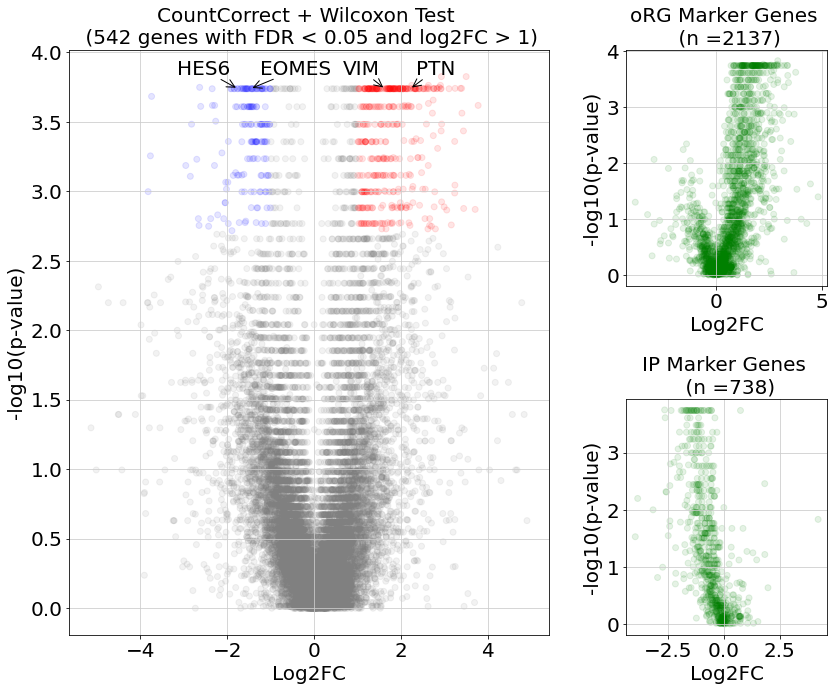

In [28]:
plot_volcano_with_reference(np.array(test_rank_isc_cpm['log2fc']),
                            np.array(test_rank_isc_cpm['qval']),
                            np.array(test_rank_isc_cpm['pval']),
                            np.array(test_rank_isc_cpm['gene']),
                            542,
                            group1_reference, group2_reference,
                            width = 12, height = 10,
                            n_max_genes = 0,
                            alpha = 0.05,
                            genesOfInterest = np.array(('EOMES', 'HES6', 'PTN', 'VIM')),
                            saveFig = '/nfs/team283/aa16/KR_NAS/0_publication_figures/Figure4C_DE-Analysis.pdf')

0.9479126185080289
0.22236360600844027


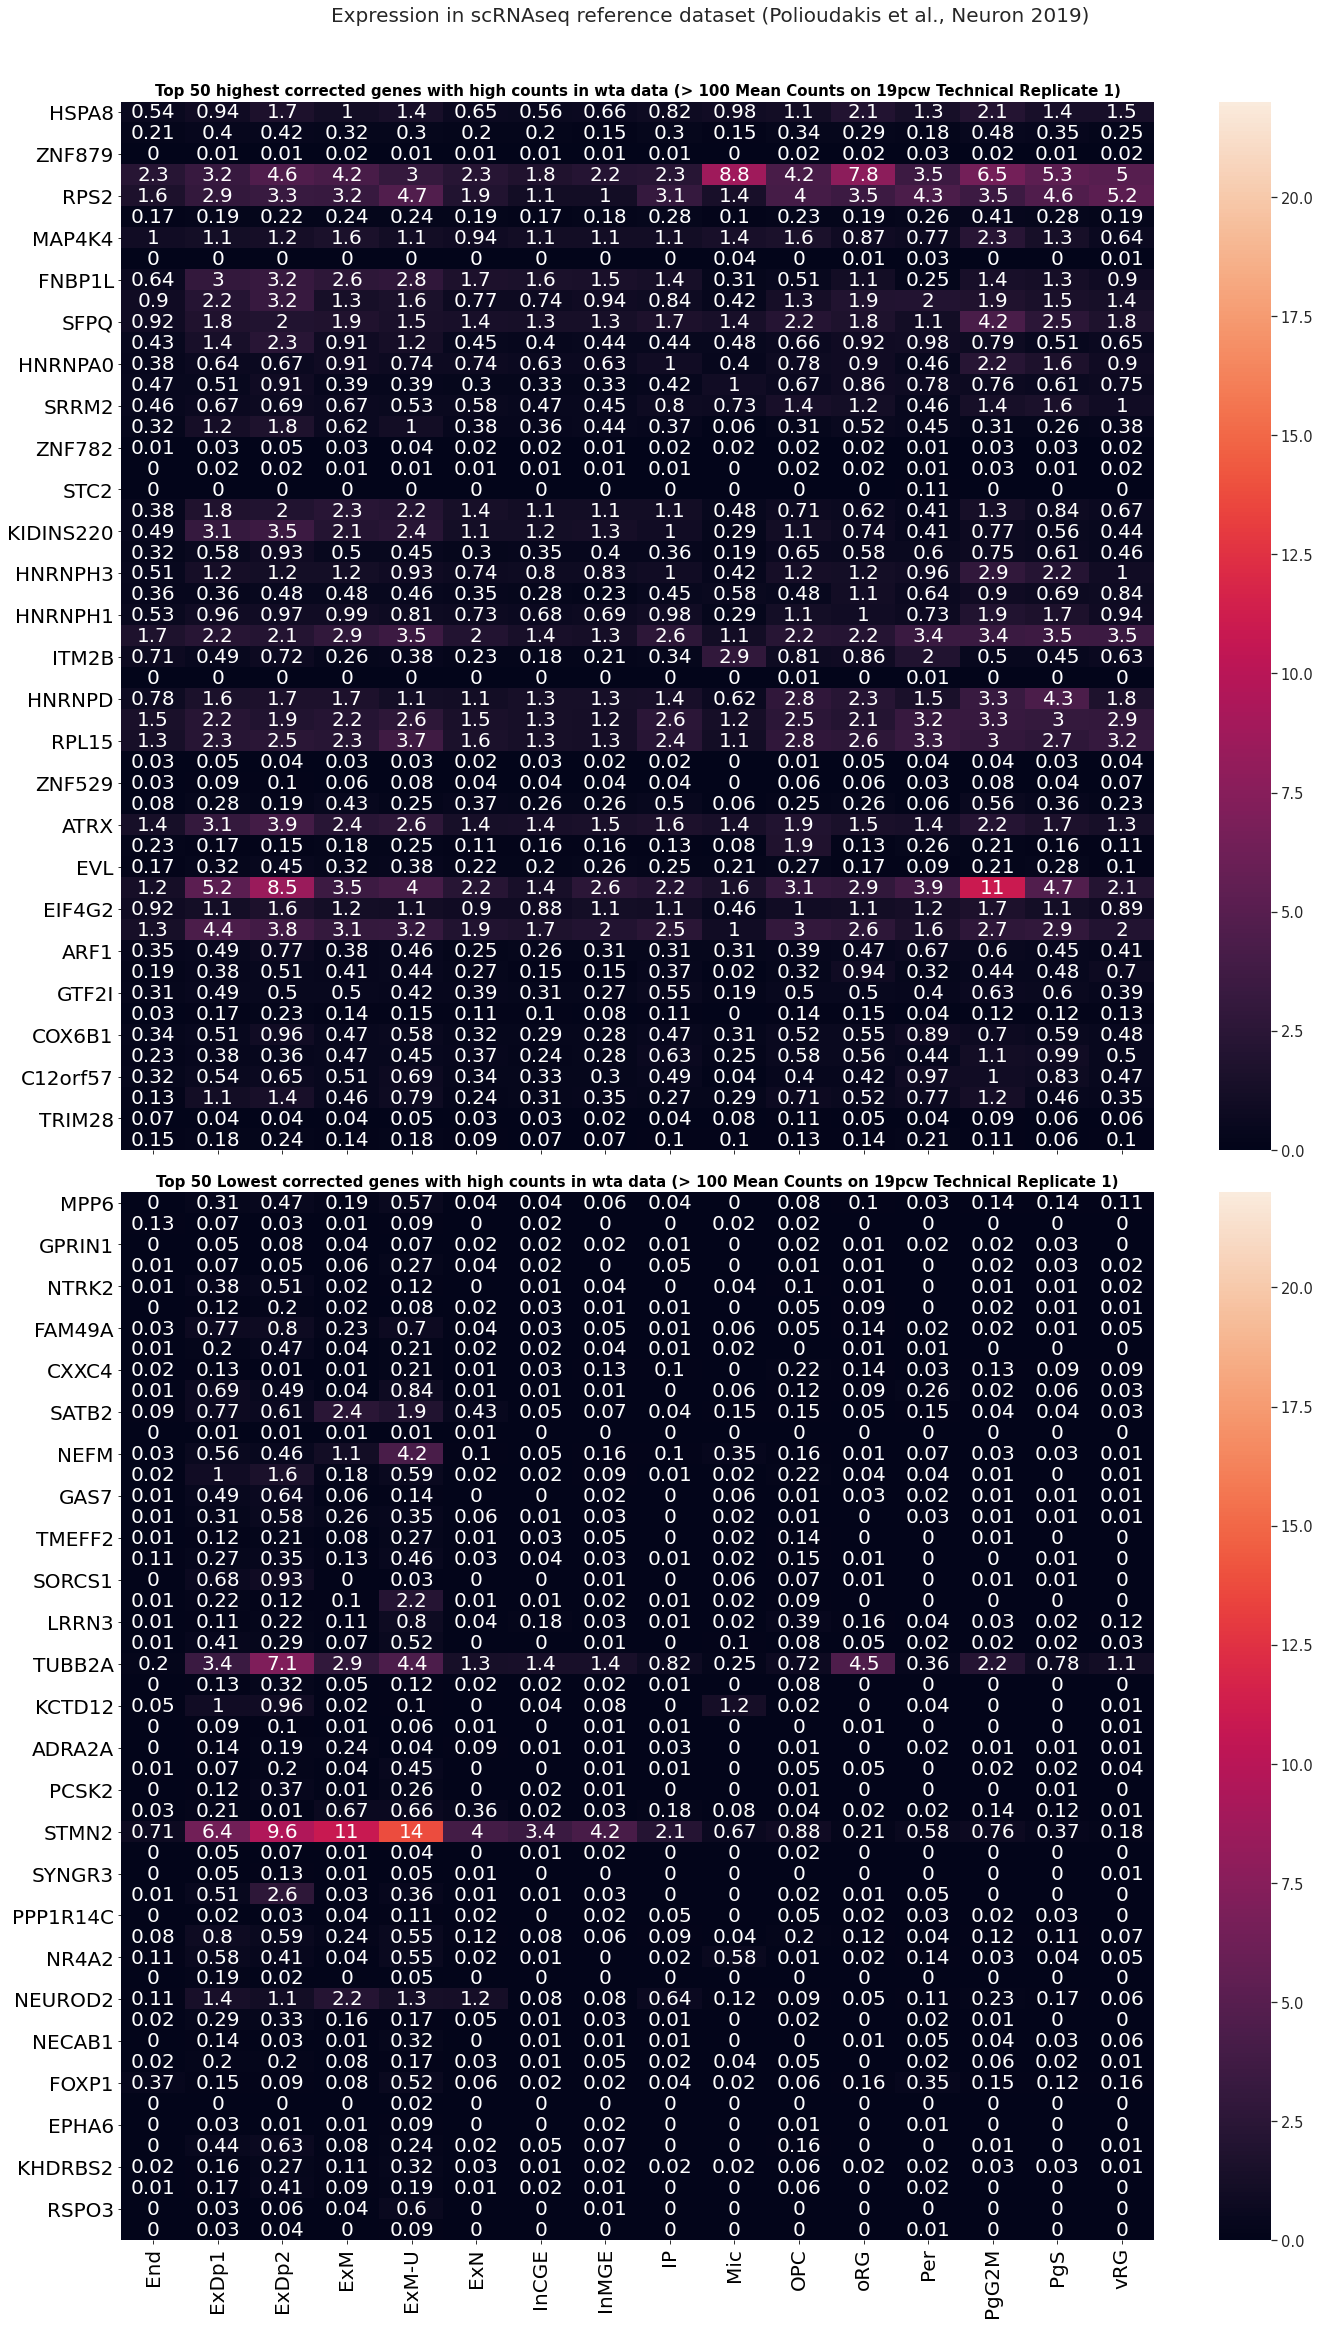

In [29]:
rankedGenes = ProbeCounts_GeneralModel_V2.rank_X_corrected_genes(mod1)
rankedGenes = rankedGenes.loc[rankedGenes['Mean Counts'] > 100,:]
rankedGenes = rankedGenes.sort_values('Removed Counts', ascending = False)

# Get reference scRNAseq data:
meanExpression_sc = pd.read_csv(path + "data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)

# Make our gene list:
commonGenes = [rankedGenes['Gene'].iloc[i] for i in range(len(rankedGenes)) if rankedGenes['Gene'].iloc[i] in meanExpression_sc.index]
topGenes = commonGenes[0:50]
bottomGenes = commonGenes[-50:]
# celltypeMarkers = np.array(('HES1', 'STMN2', 'VIM', 'SATB2', 'MEF2C', 'DLX1'))
# lookup_genes = np.concatenate([topGenes, celltypeMarkers])

fig, ax = plt.subplots(2,1, sharex = True, figsize = (20,33))
sns.set(font_scale=1.33)
ax[0].set_title('Top 50 highest corrected genes with high counts in wta data (> 100 Mean Counts on 19pcw Technical Replicate 1)',
               fontweight="bold", size=15)
ax[0] = sns.heatmap(np.round(meanExpression_sc.loc[topGenes,:],2), annot = True,  annot_kws={"size": 20},
           vmin = 0, vmax = 22, ax = ax[0])
ax[1].set_title('Top 50 Lowest corrected genes with high counts in wta data (> 100 Mean Counts on 19pcw Technical Replicate 1)',
               fontweight="bold", size=15)
ax[1] = sns.heatmap(np.round(meanExpression_sc.loc[bottomGenes,:],2), annot = True,  annot_kws={"size": 20},
           vmin = 0, vmax = 22, ax = ax[1])
plt.suptitle('Expression in scRNAseq reference dataset (Polioudakis et al., Neuron 2019)')
plt.tight_layout()
fig.subplots_adjust(top=0.94)
plt.savefig('/nfs/team283/aa16/KR_NAS/0_publication_figures/SuppFig_Most+LeastCorrectedGenes_AbsoluteCountsRemoved_Heatmap.pdf')
rankedGenes.loc[np.concatenate([topGenes, bottomGenes]),:].to_csv('/nfs/team283/aa16/KR_NAS/0_publication_tables/Most+LeastCorrectedGenes_AbsoluteCountsRemoved.csv')
print(np.mean(np.mean(meanExpression_sc.loc[topGenes,:], axis = 1)))
print(np.mean(np.mean(meanExpression_sc.loc[bottomGenes,:], axis = 1)))

0.09523377067564978
0.7728320139955284


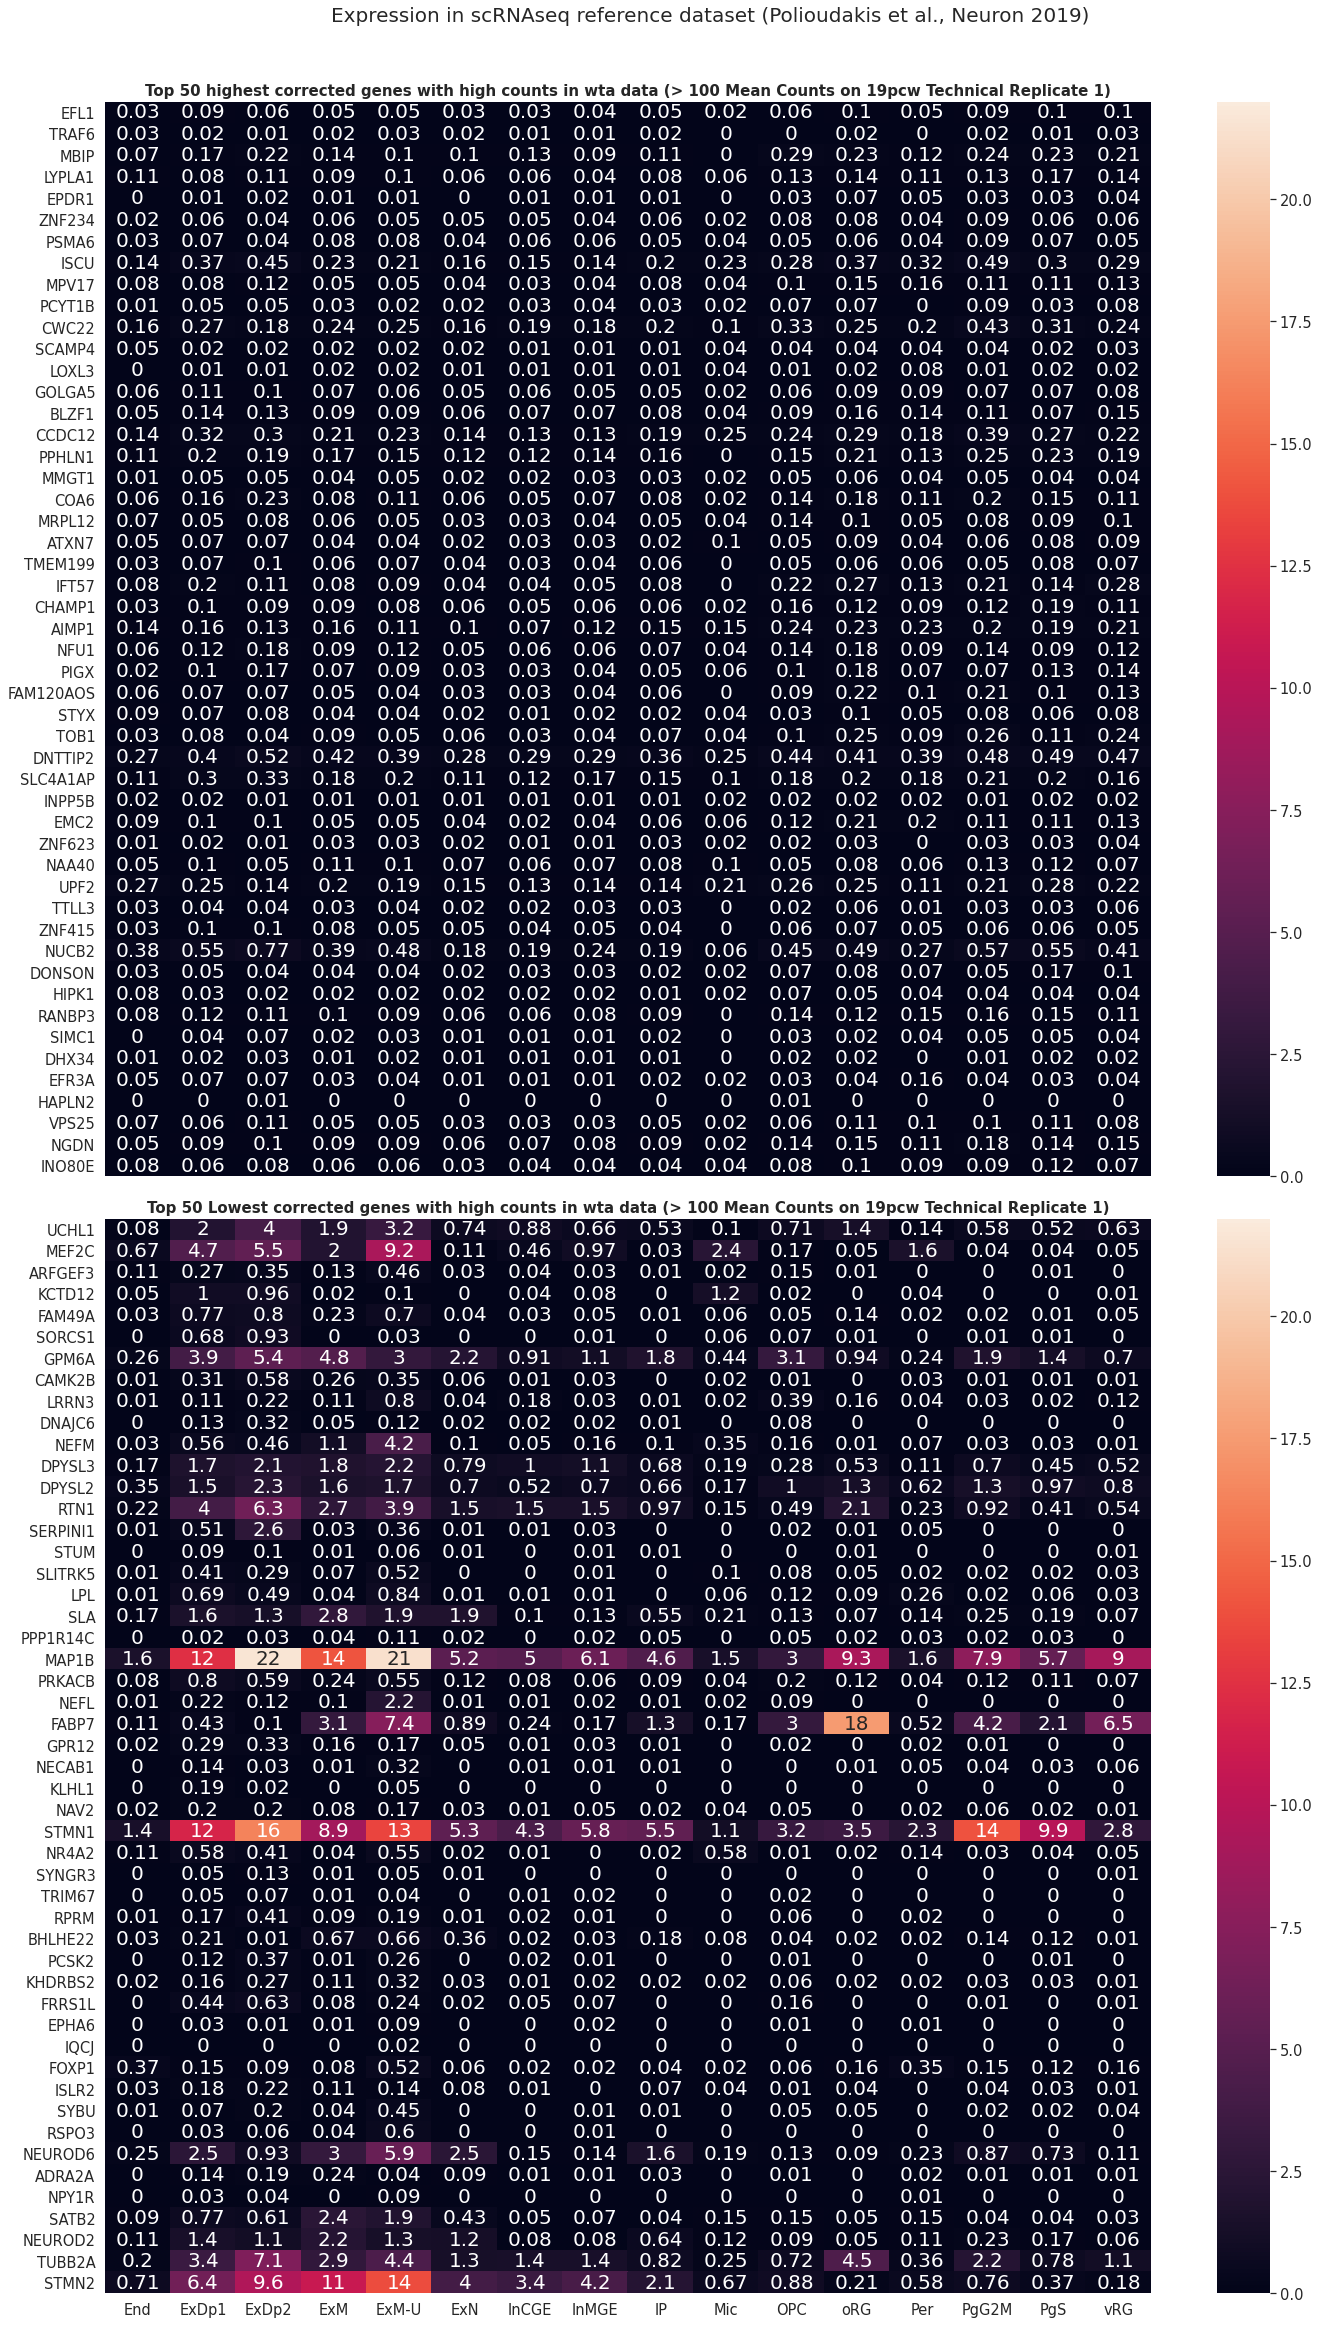

In [30]:
rankedGenes = ProbeCounts_GeneralModel_V2.rank_X_corrected_genes(mod1)
rankedGenes = rankedGenes.loc[rankedGenes['Mean Counts'] > 100,:]
rankedGenes = rankedGenes.sort_values('Fraction Removed Counts (Mean)', ascending = False)

# Get reference scRNAseq data:
meanExpression_sc = pd.read_csv(path + "data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)

# Make our gene list:
commonGenes = [rankedGenes['Gene'].iloc[i] for i in range(len(rankedGenes)) if rankedGenes['Gene'].iloc[i] in meanExpression_sc.index]
topGenes = commonGenes[0:50]
bottomGenes = commonGenes[-50:]
# celltypeMarkers = np.array(('HES1', 'STMN2', 'VIM', 'SATB2', 'MEF2C', 'DLX1'))
# lookup_genes = np.concatenate([topGenes, celltypeMarkers])

fig, ax = plt.subplots(2,1, sharex = True, figsize = (20,33))
sns.set(font_scale=1.33)
ax[0].set_title('Top 50 highest corrected genes with high counts in wta data (> 100 Mean Counts on 19pcw Technical Replicate 1)',
               fontweight="bold", size=15)
ax[0] = sns.heatmap(np.round(meanExpression_sc.loc[topGenes,:],2), annot = True,  annot_kws={"size": 20},
           vmin = 0, vmax = 22, ax = ax[0])
ax[1].set_title('Top 50 Lowest corrected genes with high counts in wta data (> 100 Mean Counts on 19pcw Technical Replicate 1)',
               fontweight="bold", size=15)
ax[1] = sns.heatmap(np.round(meanExpression_sc.loc[bottomGenes,:],2), annot = True,  annot_kws={"size": 20},
           vmin = 0, vmax = 22, ax = ax[1])
plt.suptitle('Expression in scRNAseq reference dataset (Polioudakis et al., Neuron 2019)')
plt.tight_layout()
fig.subplots_adjust(top=0.94)
plt.savefig('/nfs/team283/aa16/KR_NAS/0_publication_figures/SuppFig_Most+LeastCorrectedGenes_FractionRemoved_Heatmap.pdf')
rankedGenes.loc[np.concatenate([topGenes, bottomGenes]),:].to_csv('/nfs/team283/aa16/KR_NAS/0_publication_tables/Most+LeastCorrectedGenes_FractionRemoved.csv')
print(np.mean(np.mean(meanExpression_sc.loc[topGenes,:], axis = 1)))
print(np.mean(np.mean(meanExpression_sc.loc[bottomGenes,:], axis = 1)))

Show the same data in scatter plot:

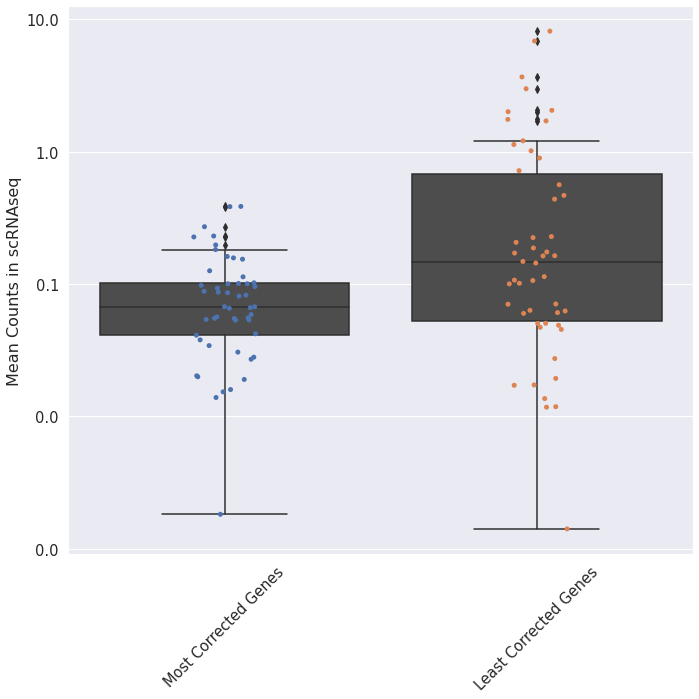

In [37]:
rankedGenes = ProbeCounts_GeneralModel_V2.rank_X_corrected_genes(mod1)
rankedGenes = rankedGenes.loc[rankedGenes['Mean Counts'] > 100,:]
rankedGenes = rankedGenes.sort_values('Fraction Removed Counts (Mean)', ascending = False)

# Get reference scRNAseq data:
meanExpression_sc = pd.read_csv(path + "data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)

# Make our gene list:
commonGenes = [rankedGenes['Gene'].iloc[i] for i in range(len(rankedGenes)) if rankedGenes['Gene'].iloc[i] in meanExpression_sc.index]
topGenes = commonGenes[0:50]
bottomGenes = commonGenes[-50:]

np.mean(meanExpression_sc.loc[topGenes,:], axis = 1)
np.mean(meanExpression_sc.loc[bottomGenes,:], axis = 1)

df = pd.DataFrame(columns = ['Category', "ExpressionInScRNAseq"])
df['Category'] = np.concatenate([np.repeat('Most Corrected Genes', 50), np.repeat('Least Corrected Genes', 50)])
df['ExpressionInScRNAseq'] = np.concatenate([np.mean(meanExpression_sc.loc[topGenes,:], axis = 1),
                                             np.mean(meanExpression_sc.loc[bottomGenes,:], axis = 1)])

fig, ax = plt.subplots(1,1,figsize = (10,10))
ax = sns.stripplot(x="Category", y="ExpressionInScRNAseq", data=df,  ax = ax)
ax = sns.boxplot(x="Category", y="ExpressionInScRNAseq", data=df, color=".3")
ax.set_ylabel('Mean Counts in scRNAseq')
ax.set_xlabel(None)
ax.set_yscale('log', basey = 10)
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/nfs/team283/aa16/KR_NAS/0_publication_figures/SuppFig_50Most+LeastCorrectedGenesByFractionRemoved_JitterPlotBoxPlot.pdf')

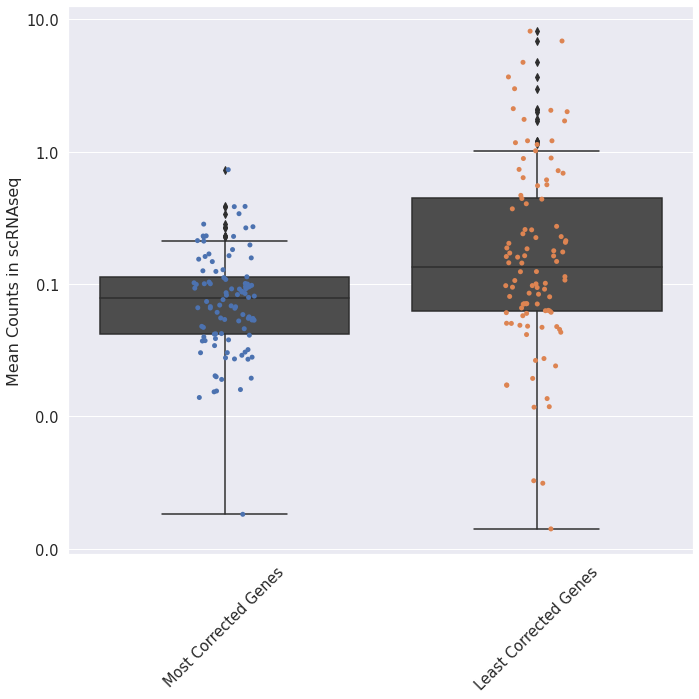

In [39]:
rankedGenes = ProbeCounts_GeneralModel_V2.rank_X_corrected_genes(mod1)
rankedGenes = rankedGenes.loc[rankedGenes['Mean Counts'] > 100,:]
rankedGenes = rankedGenes.sort_values('Fraction Removed Counts (Mean)', ascending = False)

# Get reference scRNAseq data:
meanExpression_sc = pd.read_csv(path + "data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)

# Make our gene list:
commonGenes = [rankedGenes['Gene'].iloc[i] for i in range(len(rankedGenes)) if rankedGenes['Gene'].iloc[i] in meanExpression_sc.index]
topGenes = commonGenes[0:100]
bottomGenes = commonGenes[-100:]

np.mean(meanExpression_sc.loc[topGenes,:], axis = 1)
np.mean(meanExpression_sc.loc[bottomGenes,:], axis = 1)

df = pd.DataFrame(columns = ['Category', "ExpressionInScRNAseq"])
df['Category'] = np.concatenate([np.repeat('Most Corrected Genes', 100), np.repeat('Least Corrected Genes', 100)])
df['ExpressionInScRNAseq'] = np.concatenate([np.mean(meanExpression_sc.loc[topGenes,:], axis = 1),
                                             np.mean(meanExpression_sc.loc[bottomGenes,:], axis = 1)])

fig, ax = plt.subplots(1,1,figsize = (10,10))
ax = sns.stripplot(x="Category", y="ExpressionInScRNAseq", data=df,  ax = ax)
ax = sns.boxplot(x="Category", y="ExpressionInScRNAseq", data=df, color=".3")
ax.set_ylabel('Mean Counts in scRNAseq')
ax.set_xlabel(None)
ax.set_yscale('log', basey = 10)
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/nfs/team283/aa16/KR_NAS/0_publication_figures/SuppFig_100Most+LeastCorrectedGenesByFractionRemoved_JitterPlotBoxPlot.pdf')

Show ratio of scRNAseq expression in most and least corrected genes:

In [251]:
ratio = []
intervals = []
for i in range(10):
    start = i*25
    end = (i+1)*25
    rankedGenes = ProbeCounts_GeneralModel_V2.rank_X_corrected_genes(mod1)
    rankedGenes = rankedGenes.loc[rankedGenes['Mean Counts'] > start,:]
    rankedGenes = rankedGenes.loc[rankedGenes['Mean Counts'] < end,:]
    rankedGenes = rankedGenes.sort_values('Removed Counts', ascending = False)

    commonGenes = [rankedGenes['Gene'].iloc[i] for i in range(len(rankedGenes)) if rankedGenes['Gene'].iloc[i] in meanExpression_sc.index]
    topGenes = commonGenes[0:25]
    bottomGenes = commonGenes[-25:]
    ratio += [np.mean(np.mean(meanExpression_sc.loc[topGenes,:], axis = 1))/np.mean(np.mean(meanExpression_sc.loc[bottomGenes,:], axis = 1))]
    intervals += [(start+end)/2]
print(np.mean(ratio))

1.4679390323455264


Text(0.5, 0, 'Mean Counts Interval')

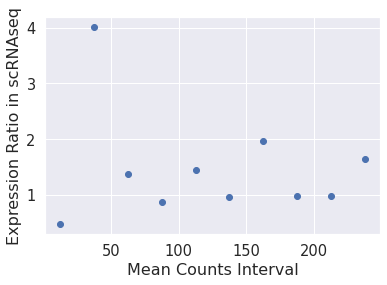

In [253]:
plt.scatter(intervals, ratio)
plt.ylabel('Expression Ratio in scRNAseq')
plt.xlabel('Mean Counts Interval')

Find genes that we think have a lot of background or little background based on scRNAseq data, by looking at the difference of their z-scored mean expression in the scRNAseq and wta data set:

In [154]:
import scipy as scipy
wta_meanExpression = np.mean(adata_slide[1].X[:,np.array([np.where(adata_slide[1].var_names == g)[0][0] for g in commonGenes])], axis = 0)
sc_meanExpression = np.mean(meanExpression_sc.loc[commonGenes,:], axis = 1)
wta_zscore = scipy.stats.zscore(np.log2(0.01+wta_meanExpression))
sc_zscore = scipy.stats.zscore(np.log2(0.01+sc_meanExpression))

(-2.0, 5.228341752146134)

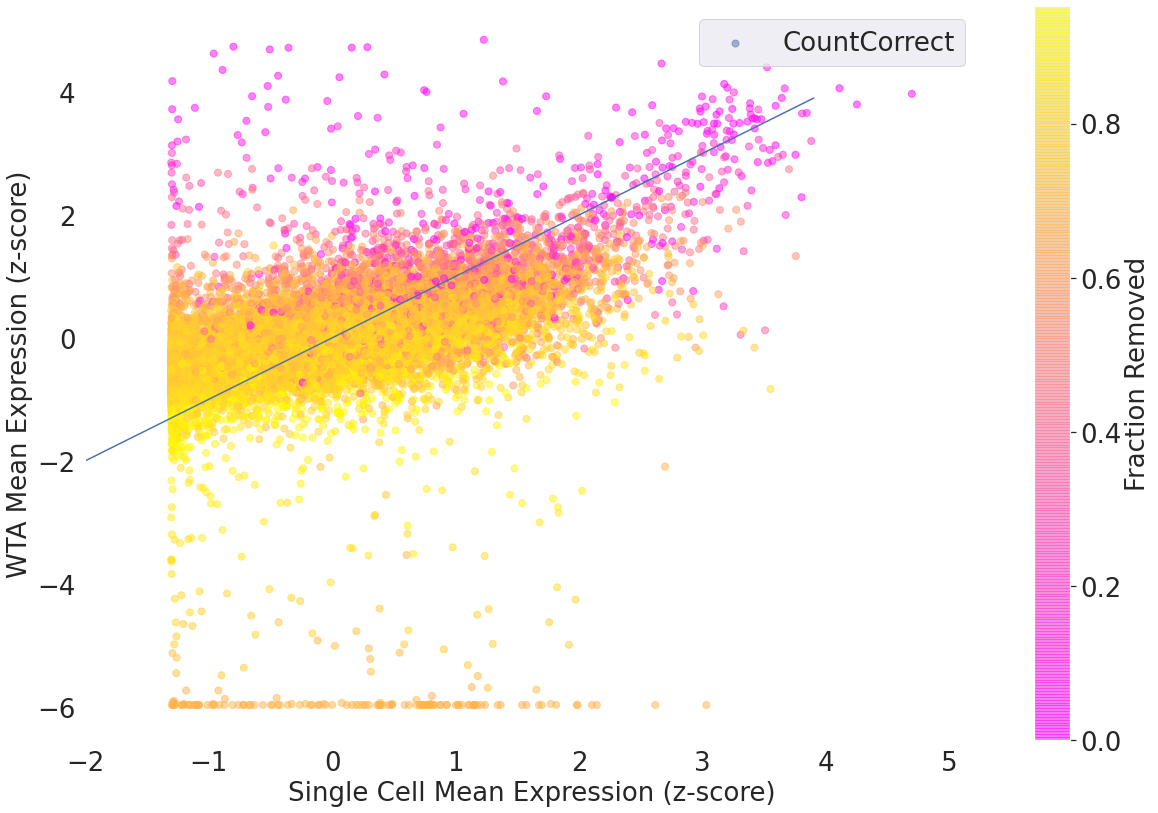

In [158]:
randomize = np.random.choice(range(len(commonGenes)), len(commonGenes), replace = False)

fig, ax = plt.subplots(1,1, figsize=(20,13.5))
mesh = ax.scatter(sc_zscore[randomize],  wta_zscore[randomize], c = np.array(rankedGenes['Fraction Removed Counts (Mean)'][commonGenes])[randomize], alpha = 0.5, label = 'CountCorrect',
   s=50, cmap = 'spring')
# plt.plot(np.arange(-6,4,0.1), np.arange(-6,4,0.1))
ax.plot()
ax.legend()
ax.set_xlabel('Single Cell Mean Expression (z-score)')
ax.set_ylabel('WTA Mean Expression (z-score)')
ax.set_facecolor('white')
ax=plt.gca()
cbar = fig.colorbar(mesh)
cbar.set_label('Fraction Removed')
ax.set_xlim(xmin = -2)


(-2.0, 5.387318277359009)

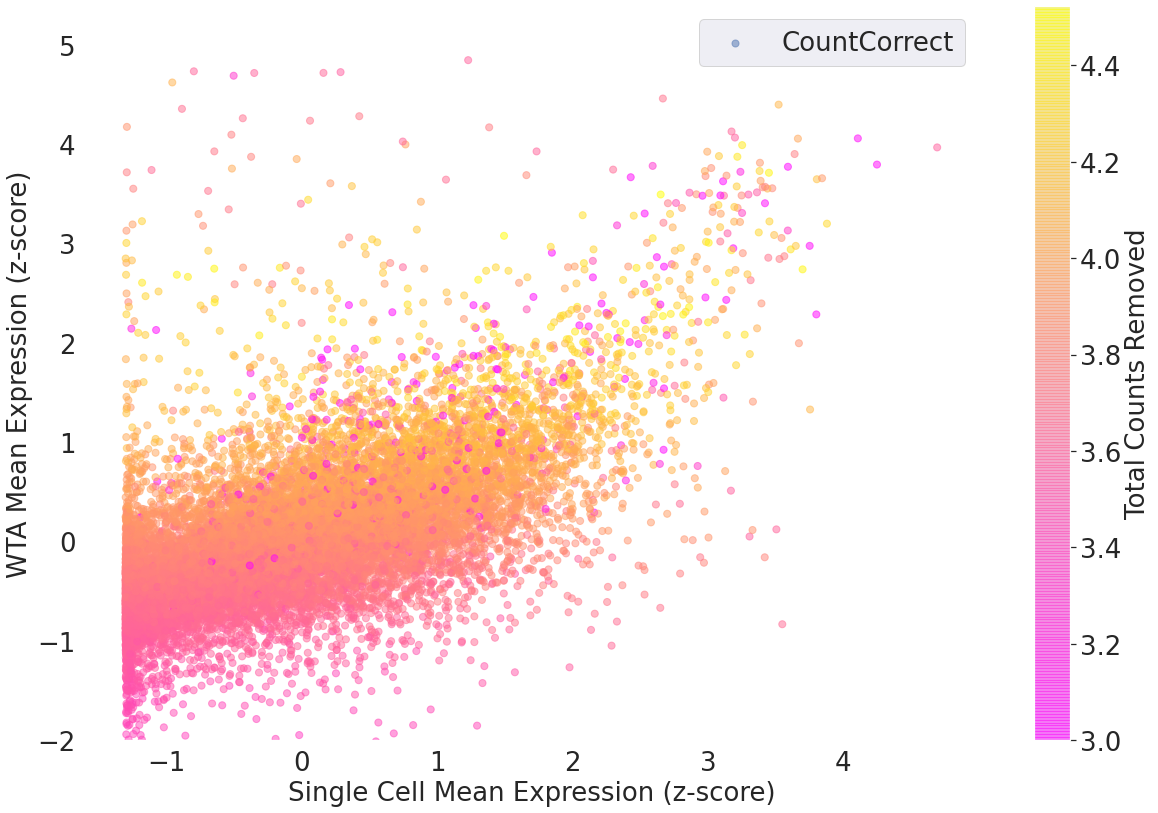

In [161]:
randomize = np.random.choice(range(len(commonGenes)), len(commonGenes), replace = False)

fig, ax = plt.subplots(1,1, figsize=(20,13.5))
mesh = ax.scatter(sc_zscore[randomize],  wta_zscore[randomize], c = np.array(np.log10(1000+rankedGenes['Removed Counts'][commonGenes]))[randomize], alpha = 0.5, label = 'CountCorrect',
   s=50, cmap = 'spring')
# plt.plot(np.arange(-6,4,0.1), np.arange(-6,4,0.1))
ax.plot()
ax.legend()
ax.set_xlabel('Single Cell Mean Expression (z-score)')
ax.set_ylabel('WTA Mean Expression (z-score)')
ax.set_facecolor('white')
ax=plt.gca()
cbar = fig.colorbar(mesh)
cbar.set_label('Total Counts Removed')
ax.set_ylim(ymin = -2)

Show scRNAseq expression vs fraction of corrected counts:

In [45]:
rankedGenes = ProbeCounts_GeneralModel_V2.rank_X_corrected_genes(mod1)
# Get reference scRNAseq data:
meanExpression_sc = pd.read_csv(path + "data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)
# Make our gene list:
commonGenes = [rankedGenes['Gene'].iloc[i] for i in range(len(rankedGenes)) if rankedGenes['Gene'].iloc[i] in meanExpression_sc.index]

AttributeError: 'AxesSubplot' object has no attribute 'xlim'

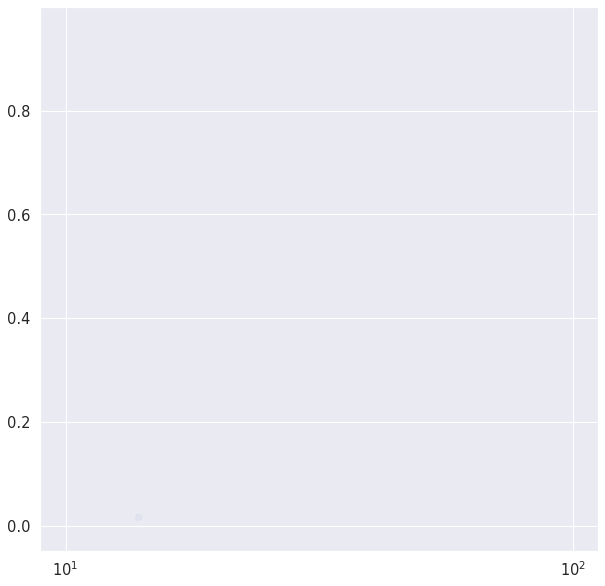

In [61]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.scatter(np.mean(meanExpression_sc.loc[commonGenes,:], axis = 1),
            rankedGenes.loc[commonGenes,:].loc[:,'Fraction Removed Counts (Mean)'], alpha = 0.05)
ax.set_xscale('log')
ax.set_xlim(xmin = 0.000001)
ax.set_xlabel('scRNAseq counts')
ax.set_ylabel('Fraction Background')

In [50]:
rankedGenes

Gene  Total Counts  Removed Counts  \
HEATR3      HEATR3          2902            2763   
C12orf42  C12orf42          3202            3035   
ERRFI1      ERRFI1          3713            3515   
EIPR1        EIPR1          3485            3297   
COPS7B      COPS7B          3030            2865   
...            ...           ...             ...   
STMN2        STMN2        144820               4   
DMTN          DMTN          5096               0   
MET            MET          5631               0   
KCNV1        KCNV1          6610               0   
KIAA0319  KIAA0319          4390               0   

          Fraction Removed Counts (Mean)  Fraction Removed Counts (q05)  \
HEATR3                          0.952102                       0.935906   
C12orf42                        0.947845                       0.933167   
ERRFI1                          0.946674                       0.931053   
EIPR1                           0.946055                       0.930560   
COPS7B                          0.945545                       0.930693   
...                                  ...                            ...   
STMN2                           0.000028                       0.000000   
DMTN                            0.000000                       0.000000   
MET                             0.000000                       0.000000   
KCNV1                           0.000000                       0.000000   
KIAA0319                        0.000000                       0.000000   

          Fraction Removed Counts (q95)  Mean Counts  
HEATR3                         0.964852           39  
C12orf42                       0.962523           43  
ERRFI1                         0.957447           50  
EIPR1                          0.959254           47  
COPS7B                         0.957756           40  
...                                 ...          ...  
STMN2                          0.000131         1957  
DMTN                           0.000589           68  
MET                            0.000178           76  
KCNV1                          0.000454           89  
KIAA0319                       0.000228           59  

[18279 rows x 7 columns]